In [13]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt

def a3(wd_coefficient, n_hid, n_iters, learning_rate,
        momentum_multiplier, do_early_stopping, mini_batch_size):

    model = initial_model(n_hid)

    # Load data
    from_data_file = sio.loadmat('data.mat')['data']
    training_data = {}
    training_data['inputs'] = from_data_file[0][0]['training'][0][0]['inputs']
    training_data['targets'] = from_data_file[0][0]['training'][0][0]['targets']
    validation_data = {}
    validation_data['inputs'] = from_data_file[0][0]['validation'][0][0]['inputs']
    validation_data['targets'] = from_data_file[0][0]['validation'][0][0]['targets']
    test_data = {}
    test_data['inputs'] = from_data_file[0][0]['test'][0][0]['inputs']
    test_data['targets'] = from_data_file[0][0]['test'][0][0]['targets']

    n_training_cases = training_data['inputs'].shape[1]
#     if n_iters != 0:
#         test_gradient(model, training_data, wd_coefficient)

    # Optimization
    theta = model_to_theta(model)
    momentum_speed = theta * 0
    training_data_losses = []
    validation_data_losses = []
    best_so_far = {}
    if do_early_stopping:
        best_so_far['theta'] = -1 # this will be overwritten soon
        best_so_far['validation_loss'] = np.inf
        best_so_far['after_n_iters'] = -1

    for optimization_iteration_i in range(1,n_iters+1):
        model = theta_to_model(theta)
        training_batch = {}
        training_batch_start = ((optimization_iteration_i-1) * mini_batch_size)\
                               % n_training_cases + 1
        training_batch['inputs'] = training_data['inputs'][:,
            training_batch_start-1 : training_batch_start-1 + mini_batch_size ]
        training_batch['targets'] = training_data['targets'][:,
            training_batch_start-1 : training_batch_start-1 + mini_batch_size ]
        gradient = model_to_theta(d_loss_by_d_model(model,
                    training_batch, wd_coefficient))
        momentum_speed = momentum_speed * momentum_multiplier - gradient
        theta = theta + momentum_speed * learning_rate

        model = theta_to_model(theta)
        training_data_losses.append(loss(model, training_data, wd_coefficient))
        validation_data_losses.append(loss(model, validation_data, wd_coefficient))

        if do_early_stopping and \
            validation_data_losses[-1] < best_so_far['validation_loss']:
          best_so_far['theta'] = theta # this will be overwritten soon
          best_so_far['validation_loss'] = validation_data_losses[-1]
          best_so_far['after_n_iters'] = optimization_iteration_i

#         if optimization_iteration_i % round(n_iters/10) == 0:
#             print('After ', optimization_iteration_i, 'optimization iterations,'
#                 ' training data loss is', training_data_losses[-1],
#                 ', and validation data loss is ', validation_data_losses[-1])

#     if n_iters != 0:
#         # check again, this time with more typical parameters
#         test_gradient(model, training_data, wd_coefficient)

    if do_early_stopping:
        print('Early stopping: validation loss was lowest after ',
            best_so_far['after_n_iters'],  'iterations. We chose the '
            'model that we had then.')
        theta = best_so_far['theta']


    # The optimization is finished. Now do some reporting.
    model = theta_to_model(theta)

    if n_iters != 0:
        plt.figure(1)
        plt.clf()
        plt.plot(range(n_iters),training_data_losses, 'b')
        plt.plot(range(n_iters),validation_data_losses, 'r')
        plt.legend(['training', 'validation'])
        plt.ylabel('loss')
        plt.xlabel('iteration number')
        plt.show()

    datas2 = [training_data, validation_data, test_data]
    data_names = ['training', 'validation', 'test']
    for data_i in range (0,3):
        data = datas2[data_i]
        data_name = data_names[data_i]
        print('The loss on the ', data_name, "data is ",
              loss(model, data, wd_coefficient))
        if wd_coefficient != 0:
            print('The classification loss (i.e. without weight decay) on the ',
                data_name, "data is ", loss(model, data, 0))
        print('The classification error rate on the', data_name, 'data is ',
            classification_performance(model, data))

def test_gradient(model, data, wd_coefficient):
    base_theta = model_to_theta(model)
    h = 0.01
    correctness_threshold = 0.00001
    analytic_gradient = model_to_theta(
                d_loss_by_d_model(model, data, wd_coefficient))
    # Test the gradient not for every element of theta, because that's
    # a lot of work. Test for only a few elements.
    for i in range(1,101):

        # 1299721 is prime and thus ensures a somewhat random-like
        # selection of indices
        test_index = (i * 1299721) % base_theta.shape[0]

        analytic_here = analytic_gradient[test_index]
        theta_step = base_theta * 0
        theta_step[test_index] = h
        contribution_distances = [-4, -3, -2, -1, 1, 2, 3, 4]
        contribution_weights = [1/280, -4/105, 1/5, -4/5, 4/5, -1/5, 4/105, -1/280]
        temp = 0
        for contribution_index in range(8):
            temp = temp + loss(theta_to_model(
                    base_theta +
                    theta_step * contribution_distances[contribution_index]),
                data,
                wd_coefficient) * contribution_weights[contribution_index]

        fd_here = temp / h
        diff = np.abs(analytic_here - fd_here)
        if diff < correctness_threshold:
            continue
        if diff / (np.abs(analytic_here) + np.abs(fd_here)) < \
                        correctness_threshold:
            continue

        print('Error! Theta element #', test_index+1 , ', with value ',
            base_theta[test_index], 'has finite difference gradient', fd_here,
            'but analytic gradient is', analytic_here,'That looks like an error.')
        quit()

    print('Gradient test passed. That means that the gradient that your '
          'code computed is within 0.001% of the gradient that the finite'
          ' difference approximation computed, so the gradient calculation'
          ' procedure is probably correct (not certainly, but probably).')

def logistic(input):
    return 1 / (1 + np.exp(-input))

def log_sum_exp_over_rows(a):
    # This computes log(sum(exp(a), axis=0)) in a numerically stable way
    maxs_small = np.reshape(np.amax(a, axis=0),(1,-1), order="F")
    maxs_big = np.tile(maxs_small, (a.shape[0], 1))
    ret = np.log(np.sum(np.exp(a - maxs_big), axis=0)) + maxs_small
    return ret

def loss(model, data, wd_coefficient):
    # model['input_to_hid'] is a matrix of size <number of hidden units> by
    # <number of inputs i.e. 256>. It contains the weights from the input
    # units to the hidden units.
    # model['hid_to_class'] is a matrix of size <number of classes i.e. 10>
    # by <number of hidden units>. It contains the weights from the hidden
    # units to the softmax units.
    # data['inputs'] is a matrix of size <number of inputs i.e. 256> by
    # <number of data cases>. Each column describes a different data case.
    # data['targets'] is a matrix of size <number of classes i.e. 10> by
    # <number of data cases>. Each column describes a different data case.
    # It contains a one-of-N encoding of the class, i.e. one element in
    # every column is 1 and the others are 0.

    # Before we can calculate the loss, we need to calculate a variety
    # of intermediate values, like the state of the hidden units.

    # input to the hidden units, i.e. before the logistic.
    # size: <number of hidden units> by <number of data cases>
    hid_input = np.dot(model['input_to_hid'], data['inputs'])

    # output of the hidden units, i.e. after the logistic.
    # size: <number of hidden units> by <number of data cases>
    hid_output = logistic(hid_input)

    # input to the components of the softmax.
    # size: <number of classes, i.e. 10> by <number of data cases>
    class_input = np.dot(model['hid_to_class'], hid_output)

    # The following three lines of code implement the softmax.
    # However, it's written differently from what the lectures say.
    # In the lectures, a softmax is described using an exponential
    # divided by a sum of exponentials.
    # What we do here is exactly equivalent (you can check the math or
    # just check it in practice), but this is more numerically stable.
    # "Numerically stable" means that this way, there will never be really
    # big numbers involved.
    # The exponential in the lectures can lead to really big numbers, which
    # are fine in mathematical equations, but can lead to all sorts of
    # problems in Octave.
    # Octave isn't well prepared to deal with really large numbers, like
    # the number 10 to the power 1000. Computations with such numbers get
    # unstable, so we avoid them.

    # log(sum(exp of class_input)) is what we subtract to get properly
    # normalized log class probabilities. size: <1> by <number of data cases>
    class_normalizer = log_sum_exp_over_rows(class_input)

    # log of probability of each class. size: <number of classes, i.e. 10>
    # by <number of data cases>
    log_class_prob = class_input - \
                     np.tile(class_normalizer, (class_input.shape[0], 1))

    # probability of each class. Each column (i.e. each case) sums to 1.
    # size: <number of classes, i.e. 10> by <number of data cases>
    class_prob = np.exp(log_class_prob)

    # select the right log class probability using that sum; then take the
    # mean over all data cases.
    classification_loss = -np.mean(np.sum(log_class_prob * data['targets'],
                                          axis=0))

    # weight decay loss. very straightforward: E = 1/2 * wd_coeffecient * theta^2
    wd_loss = np.sum(model_to_theta(model)*model_to_theta(model))/2*wd_coefficient

    ret = classification_loss + wd_loss

    return ret



def model_to_theta(model):
    # This function takes a model (or gradient in model form),
    # and turns it into one long vector. See also theta_to_model.
    input_to_hid_transpose = np.transpose(model['input_to_hid'])
    hid_to_class_transpose = np.transpose(model['hid_to_class'])

    ret = np.concatenate((input_to_hid_transpose.flatten('F'),
                          hid_to_class_transpose.flatten('F')), axis=0)
    return ret

def theta_to_model(theta):
    # This function takes a model (or gradient) in the form of one long
    # vector (maybe produced by model_to_theta), and restores it to the
    # structure format, i.e. with fields .input_to_hid and .hid_to_class,
    # both matrices.

    ret = {}

    n_hid = int(theta.shape[0] / (256+10))
    ret['input_to_hid'] = np.transpose(np.reshape(
                    theta[0:256*n_hid],(256, n_hid), order="F"))
    ret['hid_to_class'] = np.transpose(
            np.reshape(theta[256*n_hid:theta.shape[0]], (n_hid, 10), order="F"))

    return ret

def initial_model(n_hid):
    n_params = (256+10) * n_hid
    as_row_vector = np.cos(np.asarray(range(n_params)))

    # We don't use random initialization, for this assignment.
    # This way, everybody will get the same results.
    ret = theta_to_model(as_row_vector * 0.1)
    return ret

def classification_performance(model, data):
    # This returns the fraction of data cases that is incorrectly
    # classified by the model.

    # input to the hidden units, i.e. before the logistic.
    # size: <number of hidden units> by <number of data cases>
    hid_input = np.dot(model['input_to_hid'], data['inputs'])

    # output of the hidden units, i.e. after the logistic.
    # size: <number of hidden units> by <number of data cases>
    hid_output = logistic(hid_input)

    # input to the components of the softmax. size: <number of classes,
    # i.e. 10> by <number of data cases>
    class_input = np.dot(model['hid_to_class'], hid_output)

    # choices is integer: the chosen class, plus 1.
    choices = np.argmax(class_input, axis=0)

    # targets is integer: the target class, plus 1.
    targets = np.argmax(data['targets'], axis=0)

    sumtmp = 0.
    for i in range(choices.shape[0]):
        if choices[i] != targets[i]:
            sumtmp = sumtmp + 1.
        else:
            sumtmp = sumtmp + 0.

    ret = sumtmp / choices.shape[0]
    return ret


In [6]:
def d_loss_by_d_model(model, data, wd_coefficient):
    # model['input_to_hid'] is a matrix of size <number of hidden units>
    # by <number of inputs i.e. 256>
    # model['hid_to_class'] is a matrix of size <number of classes i.e. 10>
    # by <number of hidden units>
    # data['inputs'] is a matrix of size <number of inputs i.e. 256> by
    # <number of data cases>. Each column describes a different data case.
    # data['targets'] is a matrix of size <number of classes i.e. 10> by
    # <number of data cases>. Each column describes a different data case.
    # It contains a one-of-N encoding of the class, i.e. one element in
    # every column is 1 and the others are 0.
    #
    # The returned object is supposed to be exactly like parameter <model>,
    # i.e. it has fields ret.input_to_hid and ret.hid_to_class. However,
    # the contents of those matrices are gradients (d loss by d model
    # parameter), instead of model parameters.
    #
    # This is the only function that you're expected to change. Right now,
    # it just returns a lot of zeros, which is obviously not the correct
    # output. Your job is to replace that by a correct computation.

    ret = {}
    dcdwih =np.zeros(model['input_to_hid'].shape)
#     print(dcdwih.shape)
    dcdwhs =np.zeros(model['hid_to_class'].shape)
    number_of_cases = len(data['targets'][0])
   
    W1 = model['input_to_hid']
    W2 = model['hid_to_class']
    for j in range(number_of_cases):
        X = (data['inputs'].T)[j].reshape(data['inputs'].T.shape[1],1)
        Y = data['targets'].T[j].reshape(data['targets'].T.shape[1],1)
        Z1 = W1@(X)
        A1 = 1/(1+np.exp(-Z1))
        Z2 = W2@A1
        A2 = np.exp(Z2)/(np.sum(np.exp(Z2)))
#         print((A2-Y).shape)
#         print(W2.shape)
#         print((A1.T@(1-A1)).shape)
#         print(X.shape)
        
        dcdwhs = dcdwhs + (A2-Y)@A1.T
        dcdwih = dcdwih + ((A2-Y).T@W2).T@(A1.T@(1-A1)).T@X.T
        
#     print(model_hc.shape)

    ret['input_to_hid'] = dcdwih/number_of_cases + wd_coefficient*model['input_to_hid']
    ret['hid_to_class'] = dcdwhs/number_of_cases + wd_coefficient*model['hid_to_class']

    return ret

Error! Theta element # 1642 , with value  0.046369533543 has finite difference gradient -0.00269888772205 but analytic gradient is -0.0269754389338 That looks like an error.
Error! Theta element # 623 , with value  0.0999375415997 has finite difference gradient -0.000629245939724 but analytic gradient is -0.00629429336853 That looks like an error.
Error! Theta element # 2264 , with value  0.0494715045845 has finite difference gradient 0.00129069669896 but analytic gradient is 0.0128815619546 That looks like an error.
Error! Theta element # 1245 , with value  0.0997502444198 has finite difference gradient -0.0009895107284 but analytic gradient is -0.0099055707942 That looks like an error.
Error! Theta element # 226 , with value  0.036731936773 has finite difference gradient -0.000833860505686 but analytic gradient is -0.00832806879328 That looks like an error.
Error! Theta element # 1867 , with value  0.0994383424259 has finite difference gradient -0.000761337552256 but analytic gradien

Error! Theta element # 1854 , with value  0.0857880551242 has finite difference gradient 0.000240479684702 but analytic gradient is 0.00240072409746 That looks like an error.
Error! Theta element # 835 , with value  -0.00927161757483 has finite difference gradient -0.000399695466356 but analytic gradient is -0.00399351686877 That looks like an error.
Error! Theta element # 2476 , with value  0.0839186304548 has finite difference gradient -0.000443521268771 but analytic gradient is -0.00442408245523 That looks like an error.
Error! Theta element # 1457 , with value  -0.0127844102569 has finite difference gradient -0.000609187460835 but analytic gradient is -0.0060958876298 That looks like an error.
Error! Theta element # 438 , with value  -0.0949668255372 has finite difference gradient -0.00216526418477 but analytic gradient is -0.0216624901097 That looks like an error.
Error! Theta element # 2079 , with value  -0.0162812330626 has finite difference gradient 0.00053577734044 but analyti

After  21 optimization iterations, training data loss is 2.30094825708 , and validation data loss is  2.30122138346
After  28 optimization iterations, training data loss is 2.29995563575 , and validation data loss is  2.30027906771
After  35 optimization iterations, training data loss is 2.29908065068 , and validation data loss is  2.29941342445
After  42 optimization iterations, training data loss is 2.29791892122 , and validation data loss is  2.29832249339
After  49 optimization iterations, training data loss is 2.29679760351 , and validation data loss is  2.29729039242
After  56 optimization iterations, training data loss is 2.29596382508 , and validation data loss is  2.29648480303
After  63 optimization iterations, training data loss is 2.29516078074 , and validation data loss is  2.29576295038
After  70 optimization iterations, training data loss is 2.29439873649 , and validation data loss is  2.29500096722
Error! Theta element # 1642 , with value  0.0549317379555 has finite dif

Error! Theta element # 213 , with value  -0.00702761490186 has finite difference gradient 5.30592054453e-05 but analytic gradient is 0.000458014848833 That looks like an error.
Error! Theta element # 1854 , with value  0.0846859733448 has finite difference gradient 0.000120111550487 but analytic gradient is 0.0013921657465 That looks like an error.
Error! Theta element # 835 , with value  -0.00729960631976 has finite difference gradient -0.000397016810416 but analytic gradient is -0.00392889453741 That looks like an error.
Error! Theta element # 2476 , with value  0.0843334105693 has finite difference gradient -0.000492846966954 but analytic gradient is -0.00485038478603 That looks like an error.
Error! Theta element # 1457 , with value  -0.00919088711886 has finite difference gradient -0.000573185464564 but analytic gradient is -0.00581785162071 That looks like an error.
Error! Theta element # 438 , with value  -0.0868699199718 has finite difference gradient -0.00218727570851 but anal

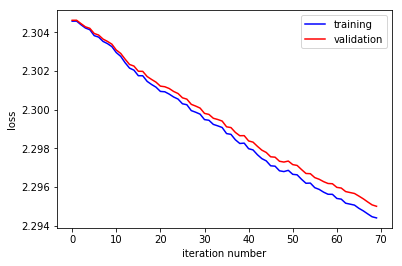

The loss on the  training data is  2.29439873649
The classification error rate on the training data is  0.878
The loss on the  validation data is  2.29500096722
The classification error rate on the validation data is  0.88
The loss on the  test data is  2.29463898534
The classification error rate on the test data is  0.8763333333333333


In [ ]:
a3(0, 10, 70, 0.005, 0, False, 4)

In [3]:
a3(0, 0, 0, 0, 0, False, 0) #Q2 2.30258509299

The loss on the  training data is  2.30258509299
The classification error rate on the training data is  0.9
The loss on the  validation data is  2.30258509299
The classification error rate on the validation data is  0.9
The loss on the  test data is  2.30258509299
The classification error rate on the test data is  0.9


After  7 optimization iterations, training data loss is 2.30375939536 , and validation data loss is  2.30386659674
After  14 optimization iterations, training data loss is 2.30215550774 , and validation data loss is  2.30234317493
After  21 optimization iterations, training data loss is 2.30094825708 , and validation data loss is  2.30122138346
After  28 optimization iterations, training data loss is 2.29995563575 , and validation data loss is  2.30027906771
After  35 optimization iterations, training data loss is 2.29908065068 , and validation data loss is  2.29941342445
After  42 optimization iterations, training data loss is 2.29791892122 , and validation data loss is  2.29832249339
After  49 optimization iterations, training data loss is 2.29679760351 , and validation data loss is  2.29729039242
After  56 optimization iterations, training data loss is 2.29596382508 , and validation data loss is  2.29648480303
After  63 optimization iterations, training data loss is 2.29516078074 , 

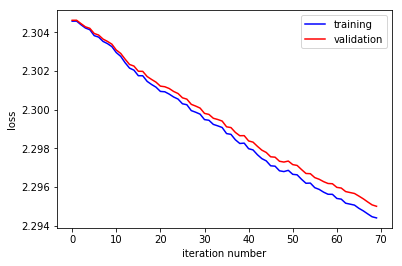

The loss on the  training data is  2.29439873649
The classification error rate on the training data is  0.878
The loss on the  validation data is  2.29500096722
The classification error rate on the validation data is  0.88
The loss on the  test data is  2.29463898534
The classification error rate on the test data is  0.8763333333333333


In [10]:
a3(0, 10, 70, 0.005, 0, False, 4) #Q3 2.29439

After  100 optimization iterations, training data loss is 0.899560217055 , and validation data loss is  1.07058477942
After  200 optimization iterations, training data loss is 0.66412269314 , and validation data loss is  0.917596425051
After  300 optimization iterations, training data loss is 0.333487647097 , and validation data loss is  0.670347309835
After  400 optimization iterations, training data loss is 0.186519367998 , and validation data loss is  0.558950249533
After  500 optimization iterations, training data loss is 0.128000358052 , and validation data loss is  0.549008559579
After  600 optimization iterations, training data loss is 0.0929182205796 , and validation data loss is  0.552258146368
After  700 optimization iterations, training data loss is 0.0756197727686 , and validation data loss is  0.562103914364
After  800 optimization iterations, training data loss is 0.0621708722977 , and validation data loss is  0.570890531135
After  900 optimization iterations, training da

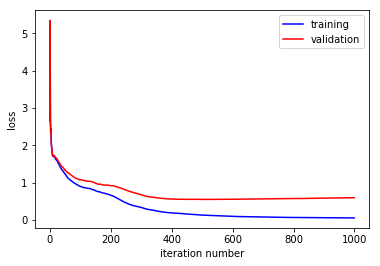

The loss on the  training data is  0.0513035047951
The classification error rate on the training data is  0.013
The loss on the  validation data is  0.592698753603
The classification error rate on the validation data is  0.107
The loss on the  test data is  0.632910204563
The classification error rate on the test data is  0.11355555555555556


In [12]:
a3(0, 200, 1000, 0.35, 0.9, False, 100) #Q6 0.592698

Early stopping: validation loss was lowest after  507 iterations. We chose the model that we had then.


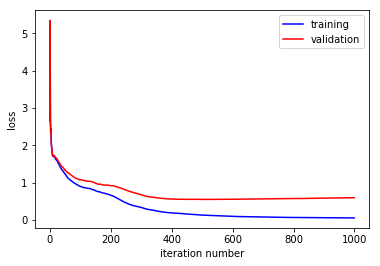

The loss on the  training data is  0.124530410097
The classification error rate on the training data is  0.03
The loss on the  validation data is  0.54726000317
The classification error rate on the validation data is  0.12
The loss on the  test data is  0.582026164368
The classification error rate on the test data is  0.12266666666666666


In [14]:
a3(0, 200, 1000, 0.35, 0.9, True, 100) #Q7 0.547260